In [744]:
import pandas as pd
df=pd.read_csv("Data Complete.csv")
df.sample(5)

,Unnamed: 0,Date,Open,Close,Adj Close,High,Low,Volume,MACD_Line,MACD_Signal,...,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,SMA_100,EMA_100,SMA_200,EMA_200
165,165,1996-08-19,7.336975,7.042425,4.626201,7.354827,7.001367,224927590,-0.055486,-0.037995,...,4.842677,4.827970,4.917259,4.874042,4.975072,4.978341,5.186799,5.022326,0.000000,4.947822
508,508,1997-12-11,11.000108,11.146490,7.613942,11.242889,10.685921,153768395,-0.617890,-0.719903,...,7.774904,7.791152,7.787342,8.209116,9.867861,9.011529,9.248429,9.019890,8.331722,8.353153
7393,7393,2025-06-16,1426.900024,1437.800049,1432.080444,1442.400024,1424.400024,8458093,15.463286,18.859717,...,1430.128210,1429.608270,1422.847302,1420.900010,1365.220452,1378.560195,1302.180220,1341.367820,1319.753782,1332.519244
6598,6598,2022-03-25,1191.823364,1197.984375,1181.142944,1207.283569,1189.285034,14222488,21.988764,9.610006,...,1127.462903,1134.735803,1092.069788,1112.186823,1095.855955,1099.147074,1101.408472,1094.047703,1073.544257,1064.111384
2322,2322,2004-11-29,35.560234,36.402824,30.590164,36.631325,34.774765,284858794,-0.379761,-0.085529,...,31.527431,31.257898,32.050218,31.701734,31.961203,31.499526,30.085140,30.712845,29.970545,29.744980


In [745]:
df=df.drop(columns=['Unnamed: 0'])

# 5. Preparing Training & Testing Data for different cases

In [746]:
train_size=int(len(df)*0.8)

### ARIMA

In [747]:
train_arima=df['Adj Close'].iloc[:train_size]
test_arima=df['Adj Close'].iloc[train_size:]

print(type(train_arima),train_arima.shape)
print(type(test_arima),test_arima.shape)

<class 'pandas.core.series.Series'> (5976,)
<class 'pandas.core.series.Series'> (1494,)


### PROPHET

In [748]:
prophet_df=df.reset_index()[['Date','Adj Close']]
prophet_df.columns=["ds","y"]

train_prophet=prophet_df.iloc[:train_size]
test_prophet=prophet_df.iloc[train_size:]

### LSTM/GRU for multi-step

In [749]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [750]:
data_multi=scaler.fit_transform(df[['Adj Close']])

In [893]:
import numpy as np
def create_multistep_sequences(data,n_steps,k):
    x=[]
    y=[]
    for i in range(n_steps,len(data)-k+1):
        x.append(data[i-n_steps:i])    # past n days
        y.append(data[i:i+k])          # next k days
    return np.array(x),np.array(y)

n_steps=100
k=1
x,y=create_multistep_sequences(data_multi,n_steps,k)

x=x.reshape((x.shape[0],x.shape[1],1))
x_train_multistep,x_test_multistep=x[:train_size],x[train_size:]
y_train_multistep,y_test_multistep=y[:train_size],y[train_size:]

### XGBOOST/RANDOMFOREST for next day close price and direction

In [752]:
next_day_df=df.drop(columns=['Date'])
next_day_df['Target']=next_day_df['Close'].shift(-1)
x_next_day=next_day_df.drop(columns=['Target'])
y_next_day=next_day_df['Target']

In [753]:
x_train_next_day,x_test_next_day=x_next_day[:train_size],x_next_day[train_size:]
y_train_next_day,y_test_next_day=y_next_day[:train_size],y_next_day[train_size:]





def prepare_xy(df, mode="regression", n_steps_in=60, n_steps_out=1):
    """
    mode: "regression", "classification", "arima", "prophet", "lstm"
    """
    if mode == "arima":
        return None, df["Close"]
    
    if mode == "prophet":
        prophet_df = df.reset_index()[["Date", "Close"]]
        prophet_df.columns = ["ds", "y"]
        return None, prophet_df
    
    if mode in ["regression", "classification"]:
        X = df[["Open", "High", "Low", "Close", "Volume", "MA_20", "MA_50", "Volatility"]]
        if mode == "regression":
            y = df["Close"].shift(-1)
        else:
            y = (df["Close"].shift(-1) > df["Close"]).astype(int)
        return X[:-1], y[:-1]
    
    if mode == "lstm":
        data = df["Close"].values
        X, y = [], []
        for i in range(len(data) - n_steps_in - n_steps_out):
            X.append(data[i:i+n_steps_in])
            y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
        return np.array(X), np.array(y)


from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

def train_model(X, y, mode="regression", model_type="xgb", n_steps_in=60, n_steps_out=1):
    if model_type == "arima":
        model = ARIMA(y, order=(5,1,0)).fit()
        return model
    
    if model_type == "prophet":
        model = Prophet()
        model.fit(y)  # here y is prophet_df
        return model
    
    if model_type in ["xgb", "rf"]:
        if mode == "regression":
            model = XGBRegressor() if model_type=="xgb" else RandomForestRegressor()
        else:
            model = XGBClassifier() if model_type=="xgb" else RandomForestClassifier()
        model.fit(X, y)
        return model
    
    if model_type in ["lstm", "gru"]:
        model = Sequential()
        if model_type == "lstm":
            model.add(LSTM(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        else:
            model.add(GRU(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer="adam", loss="mse")
        model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=10, batch_size=32, verbose=1)
        return model

# 6. Model Training

## (i) ARIMA

In [754]:
import pmdarima as pm

train_arim=np.log(train_arima)
test_arim=np.log(test_arima)

model_arima=pm.auto_arima(train_arim,verbose=False)
forecast_arima=model_arima.predict(n_periods=len(test_arim))

forecast_arima=np.exp(forecast_arima)

root_mean_squared_error(test_arima,forecast_arima)

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

203.86213167333108

In [755]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_arima,forecast_arima)*100

15.434764087372214

In [756]:
a=df['Date'].iloc[train_size:]
a=pd.to_datetime(a)

In [757]:
a.dtype

dtype('<M8[ns]')

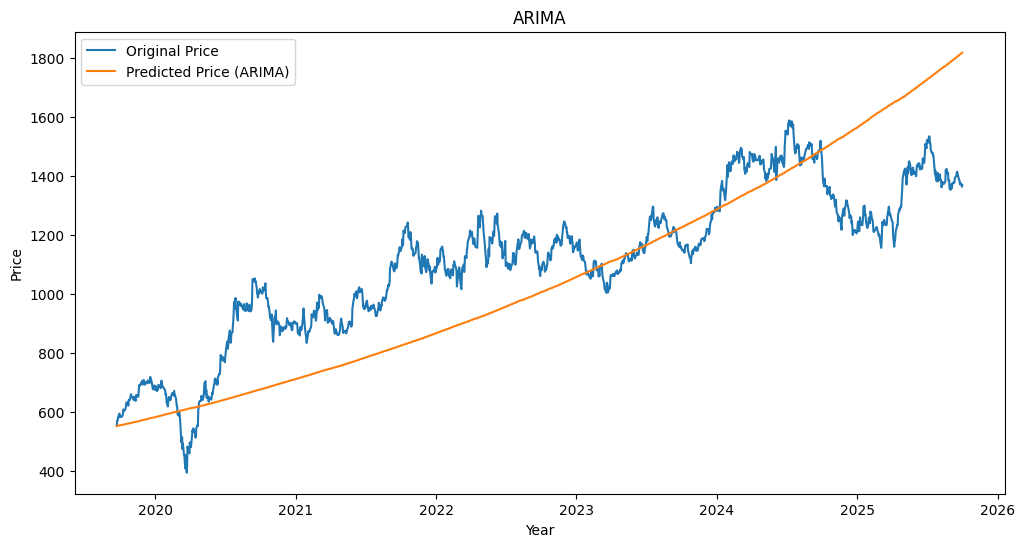

In [758]:
plt.figure(figsize=(12,6))
plt.title("ARIMA")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_arima,label="Original Price")
plt.plot(a,forecast_arima,label='Predicted Price (ARIMA)')
plt.legend()

## (ii) PROPHET

In [759]:
from prophet import Prophet

train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])

m=Prophet()
m.fit(train_prophet)

future_prophet=m.make_future_dataframe(periods=len(test_prophet))
forecast_prophet=m.predict(future_prophet)

/var/folders/nc/hvlqvddd2xj11jl0l69nx3580000gn/T/ipykernel_19660/2201988977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])
15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing


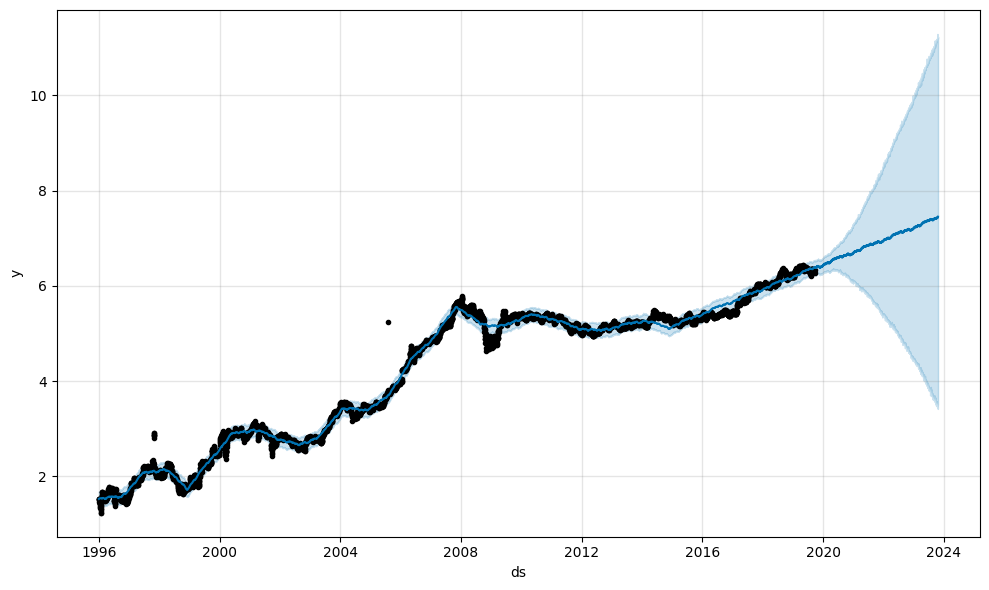

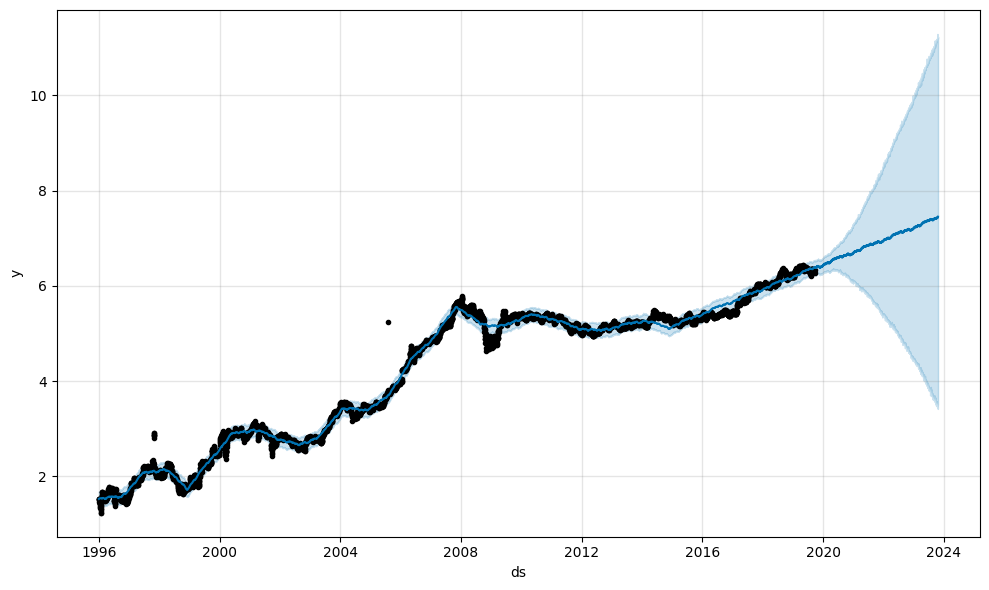

In [760]:
m.plot(forecast_prophet)

In [768]:
root_mean_squared_error(test_prophet['y'],forecast_prophet['yhat'].iloc[train_size:])

0.17279774685043017

In [769]:
test_prophet['y'],forecast_prophet['yhat'].iloc[train_size:]

(5976    6.317814
 5977    6.349192
 5978    6.349857
 5979    6.363248
 5980    6.372650
           ...   
 7465    7.224316
 7466    7.228098
 7467    7.224608
 7468    7.218177
 7469    7.221617
 Name: y, Length: 1494, dtype: float64,
 5976    6.375696
 5977    6.375641
 5978    6.388599
 5979    6.388470
 5980    6.389733
           ...   
 7465    7.449951
 7466    7.448646
 7467    7.437082
 7468    7.438435
 7469    7.452717
 Name: yhat, Length: 1494, dtype: float64)

In [763]:
np.exp(test_prophet['y']),np.exp(forecast['yhat'].iloc[train_size:])

(5976     554.359985
 5977     572.030396
 5978     572.410645
 5979     580.127502
 5980     585.607605
            ...     
 7465    1372.400024
 7466    1377.599976
 7467    1372.800049
 7468    1364.000000
 7469    1368.699951
 Name: y, Length: 1494, dtype: float64,
 5976     586.603865
 5977     586.560903
 5978     596.493431
 5979     596.397319
 5980     597.178801
            ...     
 7462    1713.221498
 7463    1716.249839
 7464    1721.816444
 7465    1727.125336
 7466    1724.791387
 Name: yhat, Length: 1491, dtype: float64)

In [770]:
test_proph=np.exp(test_prophet['y'])
predict_proph=np.exp(forecast_prophet['yhat'].iloc[train_size:])

In [771]:
root_mean_squared_error(test_proph,predict_proph)

180.75158642610637

In [772]:
mean_absolute_percentage_error(test_proph,predict_proph)*100

14.04703261780307

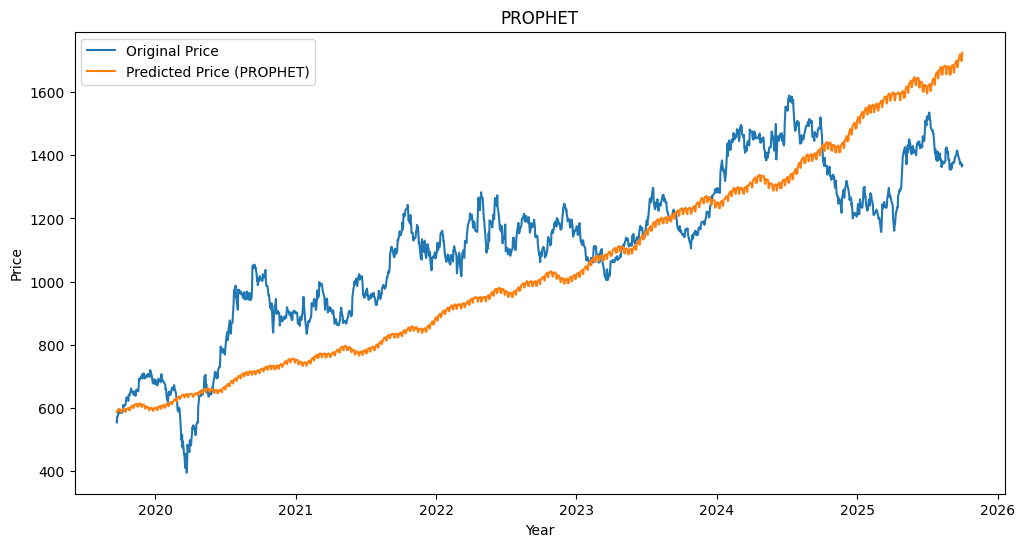

In [773]:
plt.figure(figsize=(12,6))
plt.title("PROPHET")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_proph,label='Original Price')
plt.plot(a,predict_proph,label='Predicted Price (PROPHET)')
plt.legend()

## (iii) LSTM

In [774]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU

In [894]:
lstm_model=Sequential([
    LSTM(80,input_shape=(x_train_multistep.shape[1],1),return_sequences=True),
    #Dropout(0.2),
    LSTM(60),
    #Dropout(0.3),
    Dense(y_train_multistep.shape[1])
])

lstm_model.summary()

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (None, 100, 80)        │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 60)             │        33,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,141 (234.93 KB)

 Trainable params: 60,141 (234.93 KB)

 Non-trainable params: 0 (0.00 B)

In [895]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
history_lstm=lstm_model.fit(x_train_multistep,y_train_multistep,epochs=30,batch_size=32,validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 8.5368e-04 - val_loss: 1.0848e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.4996e-05 - val_loss: 1.3825e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.1937e-05 - val_loss: 1.2304e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.5603e-05 - val_loss: 9.0947e-05
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.0472e-05 - val_loss: 1.6106e-04
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.8160e-05 - val_loss: 9.9950e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.6464e-05 - val_loss: 2.1242e-04
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.5010e-05 - val_loss: 1.1229e-04
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.7043e-05 - val_loss: 1.3270e-04
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.6848e-05 - val_loss: 1.2862e-04
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/

In [896]:
y_pred_lstm=lstm_model.predict(x_test_multistep)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [897]:
y_pred_lstm.shape,y_test_multistep.shape

((1394, 1), (1394, 1, 1))

In [898]:
y_pred_lstm,y_test_multistep

(array([[0.40291813],
        [0.40329346],
        [0.4015944 ],
        ...,
        [0.80969435],
        [0.8087522 ],
        [0.8056568 ]], dtype=float32),
 array([[[0.41486741]],
 
        [[0.4118064 ]],
 
        [[0.42207552]],
 
        ...,
 
        [[0.86356845]],
 
        [[0.85801878]],
 
        [[0.86098276]]]))

In [899]:
if y_test_multistep.shape[1]==1:
    y_test_lstm_squeezed=y_test_multistep.reshape(-1,1)
else:
    y_test_lstm_squeezed=np.squeeze(y_test_multistep)

In [900]:
y_test_lstm_squeezed.shape

(1394, 1)

In [901]:
root_mean_squared_error(y_test_lstm_squeezed,y_pred_lstm)

0.044130310005379696

In [902]:
real_lstm=scaler.inverse_transform(y_test_lstm_squeezed)
predicted_lstm=scaler.inverse_transform(y_pred_lstm)

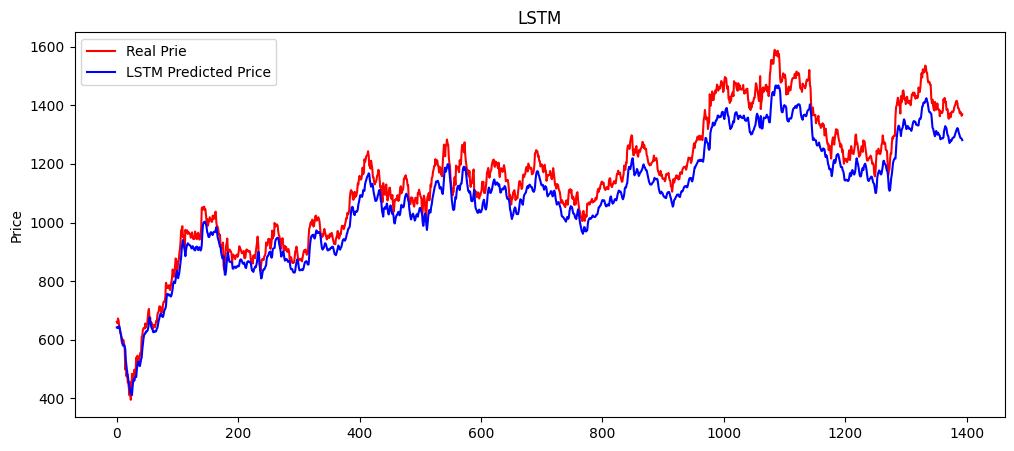

In [903]:
plt.figure(figsize=(12,5))
plt.title("LSTM")
plt.ylabel("Price")
plt.plot(real_lstm,'r',label="Real Prie")
plt.plot(predicted_lstm,'b',label="LSTM Predicted Price")
plt.legend()

In [904]:
root_mean_squared_error(real_lstm,predicted_lstm)

69.97696735089633

In [905]:
mean_absolute_percentage_error(real_lstm,predicted_lstm)*100

5.431885427032458

## (iv) GRU

In [906]:
gru_model=Sequential([
    GRU(80,input_shape=(x_train_multistep.shape[1],1),return_sequences=True),
    GRU(60),
    Dense(y_train_multistep.shape[1])
])
gru_model.summary()

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                    │ (None, 100, 80)        │        19,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 60)             │        25,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,541 (177.89 KB)

 Trainable params: 45,541 (177.89 KB)

 Non-trainable params: 0 (0.00 B)

In [907]:
gru_model.compile(loss='mean_squared_error',optimizer='adam')
history_gru=gru_model.fit(x_train_multistep,y_train_multistep,epochs=30,batch_size=32,validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.0641e-04 - val_loss: 4.2945e-05
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 7.7496e-06 - val_loss: 4.0256e-05
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 8.5970e-06 - val_loss: 3.9106e-05
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 9.7148e-06 - val_loss: 4.1366e-05
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.4916e-06 - val_loss: 4.2044e-05
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.6656e-06 - val_loss: 6.0870e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 9.2596e-06 - val_loss: 3.5529e-05
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 8.0928e-06 - val_loss: 3.5629e-05
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.2789e-06 - val_loss: 3.1275e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 8.7522e-06 - val_loss: 2.8237e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/

In [908]:
y_pred_gru=gru_model.predict(x_test_multistep)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [909]:
y_pred_gru.shape,y_test_multistep.shape

((1394, 1), (1394, 1, 1))

In [910]:
y_pred_gru,y_test_multistep

(array([[0.41691312],
        [0.41544765],
        [0.41289648],
        ...,
        [0.84516215],
        [0.84286386],
        [0.83800584]], dtype=float32),
 array([[[0.41486741]],
 
        [[0.4118064 ]],
 
        [[0.42207552]],
 
        ...,
 
        [[0.86356845]],
 
        [[0.85801878]],
 
        [[0.86098276]]]))

In [911]:
if y_test_multistep.shape[1]==1:
    y_test_gru_squeezed=y_test_multistep.reshape(-1,1)
else:
    y_test_gru_squeezed=np.squeeze(y_test_multistep)

In [912]:
y_test_gru_squeezed.shape

(1394, 1)

In [913]:
root_mean_squared_error(y_test_gru_squeezed,y_pred_gru)

0.019081210079948098

In [914]:
y_test_gru_squeezed,y_pred_gru

(array([[0.41486741],
        [0.4118064 ],
        [0.42207552],
        ...,
        [0.86356845],
        [0.85801878],
        [0.86098276]]),
 array([[0.41691312],
        [0.41544765],
        [0.41289648],
        ...,
        [0.84516215],
        [0.84286386],
        [0.83800584]], dtype=float32))

In [915]:
real_gru=scaler.inverse_transform(y_test_gru_squeezed)
predicted_gru=scaler.inverse_transform(y_pred_gru)

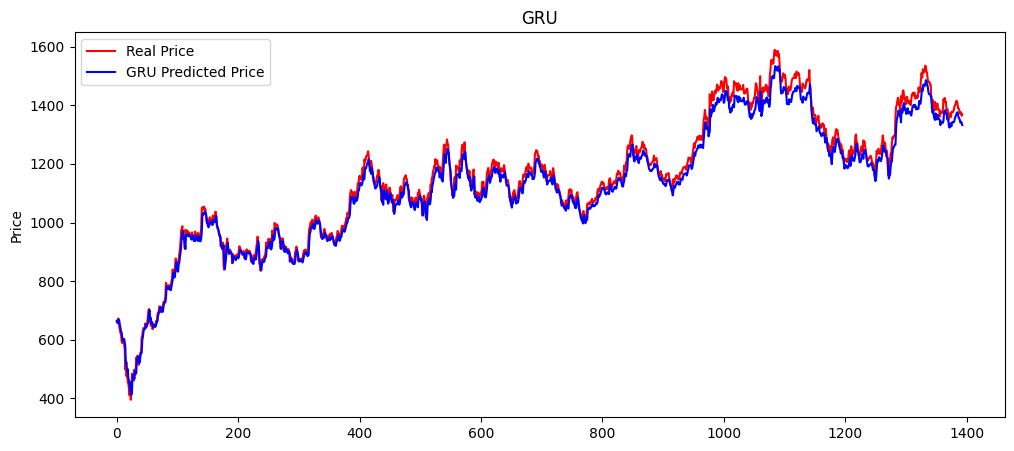

In [916]:
plt.figure(figsize=(12,5))
plt.title("GRU")
plt.ylabel("Price")
plt.plot(real_gru,'r',label="Real Price")
plt.plot(predicted_gru,'b',label="GRU Predicted Price")
plt.legend()

In [917]:
root_mean_squared_error(real_gru,predicted_gru)

30.25688123670695

In [918]:
mean_absolute_percentage_error(real_gru,predicted_gru)*100

2.1091951077945206

## (v) XGBOOST for next day close price/direction

In [863]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model_xgb=XGBRegressor()
model_xgb.fit(x_train_next_day,y_train_next_day)
y_pred_next_day_xgb=model_xgb.predict(x_test_next_day)

In [864]:
pred_xgb=y_pred_next_day_xgb[:-1]
test_xgb=y_test_next_day[:-1]

In [865]:
root_mean_squared_error(test_xgb,pred_xgb)

576.8522427840912

In [866]:
mean_absolute_percentage_error(test_xgb,pred_xgb)*100

43.41776004639218

from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 500],        # number of boosting rounds
    "max_depth": [3, 5, 7],                 # depth of trees
    "learning_rate": [0.01, 0.05, 0.1],     # step size shrinkage
    "subsample": [0.6, 0.8, 1.0],           # % of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],    # % of features used per tree
    "gamma": [0, 0.1, 0.3],                 # min loss reduction for split
    "reg_alpha": [0, 0.01, 0.1],            # L1 regularization
    "reg_lambda": [1, 1.5, 2]               # L2 regularization
}

grid_search=GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 500],        # number of boosting rounds
    "max_depth": [3, 5, 7],                 # depth of trees
    "learning_rate": [0.01, 0.05, 0.1],     # step size shrinkage
    "subsample": [0.6, 0.8, 1.0],           # % of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],    # % of features used per tree
    "gamma": [0, 0.1, 0.3],                 # min loss reduction for split
    "reg_alpha": [0, 0.01, 0.1],            # L1 regularization
    "reg_lambda": [1, 1.5, 2]               # L2 regularization
}

grid_search=GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(x_train_next_day,y_train_next_day)

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [867]:
grid_search.best_params_={'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0.01,
 'reg_lambda': 1,
 'subsample': 0.6}

In [873]:
best_xgb=XGBRegressor(colsample_bytree=0.6,
 gamma=0,
 learning_rate=0.1,
 max_depth=3,
 n_estimators=100,
 reg_alpha=0.01,
 reg_lambda=1,
 subsample=0.6)

In [875]:
best_xgb.fit(x_train_next_day,y_train_next_day)
y_pred_best_xgb=best_xgb.predict(x_test_next_day)

In [876]:
y_pred_best_xgb=y_pred_best_xgb[:-1]

In [877]:
root_mean_squared_error(test_xgb,y_pred_best_xgb)

562.1006643186141

In [878]:
mean_absolute_percentage_error(test_xgb,y_pred_best_xgb)*100

42.11194093211025

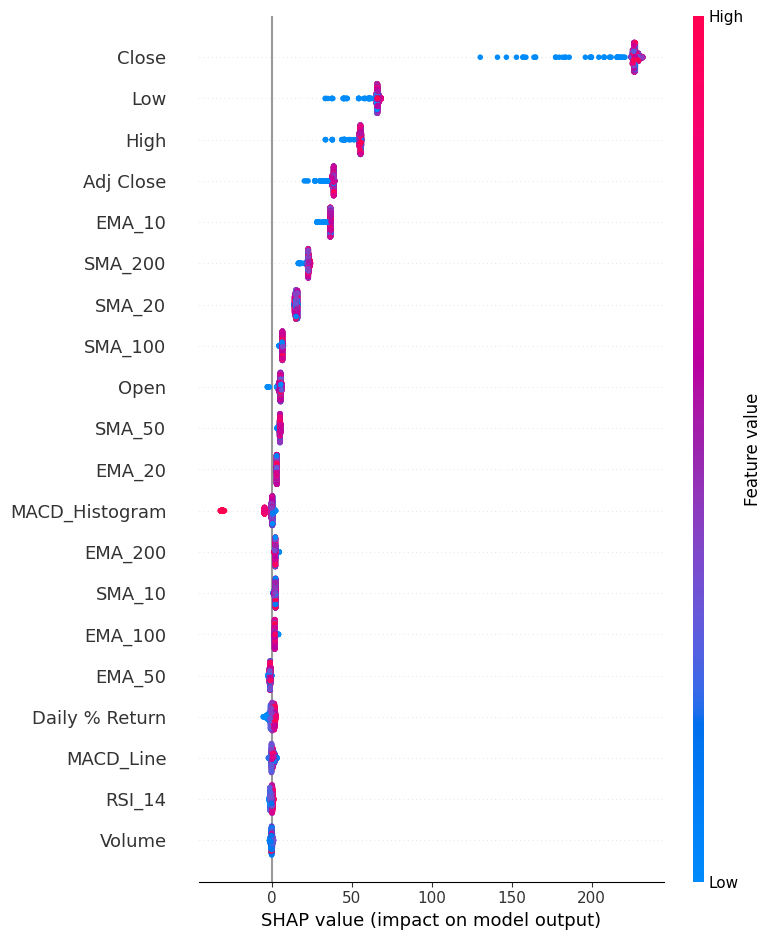

In [882]:
# ---- SHAP Explainability ----
import shap
explainer=shap.Explainer(best_xgb,x_train_next_day)
shap_values=explainer(x_test_next_day)

# Global feature importance (summary plot)
shap.summary_plot(shap_values,x_test_next_day)

# Single prediction explanation (force plot)
shap.plots.force(shap_values[0])  # explains first prediction

In [887]:
lgb_reg=LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

lgb_reg.fit(
    x_train_next_day,y_train_next_day,
    eval_set=[(x_test_next_day,y_test_next_day)],
    eval_metric='rmse',
    #early_stopping_rounds=50,
    #verbose=-1
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5976, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 153.148827


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=42)

In [888]:
lgb_pred=lgb_reg.predict(x_test_next_day)

In [890]:
root_mean_squared_error(test_xgb,lgb_pred[:-1])

564.0943242892987

In [892]:
mean_absolute_percentage_error(test_xgb,lgb_pred[:-1])*100

42.278616403477955